# JustSnap assignment - Christogeorgos Kostis Solution

# Business problem:
- Sales teams writes products descriptions in natural language, often mispelling some features of the product and ocassionally missing critical features that could help identify a product exactly.
- In the inventory system, products are stored in a relational database, making the match between the descreption and the inventory's row hard.
- Current issues include: **manual matching**, **order delays**, **not enough relevant products retrieved**, **discrepancies in the inventory**.

My solution handles and implements:
1. **Preprocessing** of the descriptions and products to enable effective modeling.
2. **Feature extraction** of each product based on its description.
3. **Matching algorithm** that returns the **strongest match** from the inventory along with the **three most probable alternatives**, handling edge cases such as synonymous colors, size formats, typos, and unstructured descriptions. All matched products include a confidence score.



# Data loading and library installation.


In [ ]:
!pip install -q rapidfuzz sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 13.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
from rapidfuzz import process, fuzz
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
product_descs = pd.read_csv("b_unstructured_descriptions.csv")
products = pd.read_csv("b_product_catalog.csv")

In [ ]:
product_descs.head(15)["Unstructured_Description"]

,Unstructured_Description
0,Do you carry Style Pants for Fall 2025?
1,"Looking for Green Boots, size L."
2,"Searching for the Modern blazer finished in dark grey, XXL size."
3,"Need blue sundress that is breathable and flexible for Fall 2024, size M."
4,"Looking for Beige Gown, size L."
5,Do you have any footwear options suitable for Fall 2025?
6,"Looking for naavy Santals by lite, size L please."
7,Need Essetnial's burundy Boluse sz XS asap.
8,"White Polo from Alpine, size M"
9,"After Black option in XS, preferably Coat."


## We can see descriptions have some typos, many different ways to structure text and many features missing.

In [ ]:
products.head(15)

,SKU,Product_Name,Category,Subcategory,Brand,Color,Size,Material,Features,Season,Price
0,SKU1000000,Nordic Jacket,Outerwear,Jacket,Nordic,Brown,XL,Polyester,Stretch|Breathable,Fall 2025,242.05
1,SKU1000001,Elite Coat,Outerwear,Coat,Elite,Tan,M,Linen,Moisture-wicking,Winter 2024,247.58
2,SKU1000002,Premium Cardigan,Outerwear,Cardigan,Premium,Black,M,Fleece,Quick-dry,Spring 2025,99.55
3,SKU1000003,Alpine Blazer,Outerwear,Blazer,Alpine,Olive,M,Nylon,UV-protection|Waterproof|Quick-dry,Winter 2025,177.36
4,SKU1000004,Alpine Parka,Outerwear,Parka,Alpine,Charcoal,XL,Wool,Windproof|Moisture-wicking|Quick-dry,Summer 2024,215.47
5,SKU1000005,Urban Vest,Outerwear,Vest,Urban,Brown,M,Polyester,Quick-dry,Spring 2024,204.43
6,SKU1000006,Urban Jacket,Outerwear,Jacket,Urban,Gray,L,Wool,Stretch|Waterproof|Windproof,Fall 2025,179.31
7,SKU1000007,Essential Coat,Outerwear,Coat,Essential,Gray,XXL,Fleece,NaN,Spring 2024,153.19
8,SKU1000008,Elite Cardigan,Outerwear,Cardigan,Elite,Cream,XS,Cotton,Quick-dry,Summer 2024,192.11
9,SKU1000009,Elite Blazer,Outerwear,Blazer,Elite,Blue,XL,Nylon,UV-protection,Summer 2024,174.40


## All products are well structured, we can explore null values later.

#Products preprocessing




## General goal is to build a new column along with the preprocessing that will store all the data each product has, in order to be encoded into embeddings.
## Steps include:
1. Lowering all text.
2. Replacing features that are partitied by ' | ' with blank space values.
3. Extracting year and season from the "Season" feature.
4. Exploring and replacing null values with appropriate values.

In [ ]:
text_columns = ["Product_Name", "Category", "Subcategory", "Brand",
             "Color", "Size", "Material", "Features", "Season"]
for c in text_columns:
    if c in products.columns:
        products[c] = products[c].astype(str).str.strip().str.lower()

In [ ]:
products['Features'] = products['Features'].astype(str).str.replace('|', ' ').str.strip().str.lower()


In [ ]:
products[['Season', 'Year']] = products['Season'].str.strip().str.lower().str.split(' ', expand=True)

In [ ]:
products[text_columns] = products[text_columns].fillna("")
products[text_columns] = products[text_columns].replace("nan", "")


In [ ]:
products.isna().sum()


,0
SKU,0
Product_Name,0
Category,0
Subcategory,0
Brand,0
Color,0
Size,0
Material,0
Features,0
Season,0


In [ ]:
products.head(25)

,SKU,Product_Name,Category,Subcategory,Brand,Color,Size,Material,Features,Season,Price,Year
0,SKU1000000,nordic jacket,outerwear,jacket,nordic,brown,xl,polyester,stretch breathable,fall,242.05,2025
1,SKU1000001,elite coat,outerwear,coat,elite,tan,m,linen,moisture-wicking,winter,247.58,2024
2,SKU1000002,premium cardigan,outerwear,cardigan,premium,black,m,fleece,quick-dry,spring,99.55,2025
3,SKU1000003,alpine blazer,outerwear,blazer,alpine,olive,m,nylon,uv-protection waterproof quick-dry,winter,177.36,2025
4,SKU1000004,alpine parka,outerwear,parka,alpine,charcoal,xl,wool,windproof moisture-wicking quick-dry,summer,215.47,2024
5,SKU1000005,urban vest,outerwear,vest,urban,brown,m,polyester,quick-dry,spring,204.43,2024
6,SKU1000006,urban jacket,outerwear,jacket,urban,gray,l,wool,stretch waterproof windproof,fall,179.31,2025
7,SKU1000007,essential coat,outerwear,coat,essential,gray,xxl,fleece,,spring,153.19,2024
8,SKU1000008,elite cardigan,outerwear,cardigan,elite,cream,xs,cotton,quick-dry,summer,192.11,2024
9,SKU1000009,elite blazer,outerwear,blazer,elite,blue,xl,nylon,uv-protection,summer,174.40,2024


## Each product needs to have an extra column that combines
- The name of the product
- The brand
- The category
- The subcategory
- The color
- The size
- The material
- The features
- The season
- And finally the year

In [ ]:
def build_text_full(row):
    parts = []

    if row["Product_Name"]:
        parts.append(row["Product_Name"])

    if row["Brand"]:
        parts.append("brand " + row["Brand"])

    if row["Category"]:
        parts.append(row["Category"])

    if row["Subcategory"]:
        parts.append(row["Subcategory"])

    if row["Color"]:
        parts.append("color " + row["Color"])

    if row["Size"]:
        parts.append("size " + row["Size"])

    if row["Material"]:
        parts.append("material " + row["Material"])

    if row["Features"]:
        parts.append("features " + row["Features"])

    if row["Season"] and row.get("Year"):
        parts.append(f"season {row['Season']} {row['Year']}")
    elif row["Season"]:
        parts.append(f"season {row['Season']}")

    return ", ".join(parts)

products["text_full"] = products.apply(build_text_full, axis=1)

In [ ]:
products["text_full"]

,text_full
0,"nordic jacket, brand nordic, outerwear, jacket, color brown, size xl, material polyester, features stretch breathable, season fall 2025"
1,"elite coat, brand elite, outerwear, coat, color tan, size m, material linen, features moisture-wicking, season winter 2024"
2,"premium cardigan, brand premium, outerwear, cardigan, color black, size m, material fleece, features quick-dry, season spring 2025"
3,"alpine blazer, brand alpine, outerwear, blazer, color olive, size m, material nylon, features uv-protection waterproof quick-dry, season winter 2025"
4,"alpine parka, brand alpine, outerwear, parka, color charcoal, size xl, material wool, features windproof moisture-wicking quick-dry, season summer 2024"
...,...
795,"style boots, brand style, footwear, boots, color black, size xxl, material fleece, season spring 2024"
796,"elite sneakers, brand elite, footwear, sneakers, color olive, size xl, material blend, season winter 2024"
797,"essential sandals, brand essential, footwear, sandals, color green, size l, material blend, features quick-dry breathable, season summer 2025"
798,"elite loafers, brand elite, footwear, loafers, color olive, size xxl, material wool, features insulated breathable, season summer 2024"


## As we can see the text_full feature now has the stracture: name, brand: brand name, category: category name and so on.
## This can help embeddings grasp the full semantic meaning of the product.

## Next we can extract unique values of the Brand, Category, Subcategory, Features and Materials to match against those in the description.

In [ ]:
brands = products['Brand'].unique().tolist()

In [ ]:
brands

['nordic',
 'elite',
 'premium',
 'alpine',
 'urban',
 'essential',
 'style',
 'modern',
 'classic',
 'comfort']

In [ ]:
categories =  products['Category'].unique().tolist()
subcategories = products['Subcategory'].unique().tolist()

In [ ]:
categories

['outerwear', 'tops', 'bottoms', 'dresses', 'footwear']

In [ ]:
subcategories

['jacket',
 'coat',
 'cardigan',
 'blazer',
 'parka',
 'vest',
 'shirt',
 'blouse',
 'sweater',
 't-shirt',
 'polo',
 'turtleneck',
 'pants',
 'jeans',
 'skirt',
 'shorts',
 'leggings',
 'dress',
 'gown',
 'sundress',
 'boots',
 'sneakers',
 'sandals',
 'loafers',
 'heels']

In [ ]:
all_features = products['Features'].str.split().sum()

features = set(all_features)

print("Unique features:", features)

Unique features: {'stretch', 'moisture-wicking', 'waterproof', 'insulated', 'wrinkle-free', 'uv-protection', 'breathable', 'windproof', 'quick-dry'}


In [ ]:
all_materials = products['Material'].str.split().sum()

materials = set(all_materials)

print("Unique materials:", materials)

Unique materials: {'denim', 'fleece', 'cashmere', 'linen', 'wool', 'blend', 'polyester', 'silk', 'cotton', 'leather', 'nylon'}


 # Descriptions preprocessing
 # Each Unstructured Description will be transformed with the following steps:
 - Lower all text.
 - Extract all of the features in the description with fuzzy matching and regex.




In [ ]:
product_descs["Unstructured_Description"] = product_descs["Unstructured_Description"].str.lower()


In [ ]:
product_descs.head(10)

,Description_ID,Unstructured_Description,Source_Channel
0,DESC0001,do you carry style pants for fall 2025?,Marketplace
1,DESC0002,"looking for green boots, size l.",Email
2,DESC0003,"searching for the modern blazer finished in dark grey, xxl size.",Website
3,DESC0004,"need blue sundress that is breathable and flexible for fall 2024, size m.",Website
4,DESC0005,"looking for beige gown, size l.",Marketplace
5,DESC0006,do you have any footwear options suitable for fall 2025?,Email
6,DESC0007,"looking for naavy santals by lite, size l please.",Email
7,DESC0008,need essetnial's burundy boluse sz xs asap.,Phone
8,DESC0009,"white polo from alpine, size m",Chat
9,DESC0010,"after black option in xs, preferably coat.",Chat


1. For colors we can have a dictionary with common colors and their synonyms, some are found from the dataset and some from googling.
2. The subcategories can be used to fill the categories if only one is they are mentioned in the description. The opposite can't happen.
3. Size is extracted just by matching the xs,m,l characters, since there is no text with the full word like Medium or Large.
4. Season and Year can be matched with regex
5. Finally Categories/Subcategories, Brands, Features and Materials can be matched from the unique values in the products dataset.

Fuzzy matching is used in Categories/Subcategories,Colors,Brands, Features and Materials

In [ ]:
colors = [
    'black','white','gray','grey','brown','red','blue','green',
    'yellow','pink','purple','orange',

    'beige','cream','ecru','ivory','tan','taupe','charcoal','navy',

    'khaki','olive','emerald','sage','mint','forest',

    'burgundy','maroon','chocolate','sand','stone',

    'peach','rose','blush','lavender','lilac',

    'teal','turquoise','cyan','fuchsia','magenta',

    'silver','gold','bronze','copper'
]

sub_to_cat = {
    # outerwear
    'jacket': 'outerwear', 'coat': 'outerwear', 'blazer': 'outerwear',
    'parka': 'outerwear', 'vest': 'outerwear', 'cardigan': 'outerwear',

    # tops
    'shirt': 'tops', 'blouse': 'tops', 'sweater': 'tops',
    't-shirt': 'tops', 'polo': 'tops', 'turtleneck': 'tops',

    # bottoms
    'pants': 'bottoms', 'jeans': 'bottoms', 'skirt': 'bottoms',
    'shorts': 'bottoms', 'leggings': 'bottoms',

    # dresses
    'dress': 'dresses', 'gown': 'dresses', 'sundress': 'dresses',

    # footwear
    'boots': 'footwear', 'sneakers': 'footwear', 'sandals': 'footwear',
    'loafers': 'footwear', 'heels': 'footwear'
}

# Extract color with fuzzy logic, cutoff is 0.7.
def extract_color(text):
    words = text.split()
    best_color = None
    best_score = 0
    for word in words:
        result = process.extractOne(word, colors, scorer=fuzz.ratio, score_cutoff=70)
        if result:
            match, score, _ = result
            if score > best_score:
                best_color = match
                best_score = score
    return best_color

# Extract size by regex.
size_pattern = r'\b(xs|s|m|l|xl|xxl)\b'
def extract_size(text):
    match = re.search(size_pattern, text.lower())
    return match.group(0) if match else None


# Extract season if it's the next list.
seasons = ['spring', 'summer', 'fall', 'winter']
def extract_season(text):
    for season in seasons:
        if season in text:
            return season
    return None

# Extract year with regex.
def extract_year(text):
    year_match = re.search(r'\b(20\d{2})\b', text)
    return year_match.group(0) if year_match else None

# Extract brands against the ones in the products dataset with fuzzy match.
# After testing .75 theshold behaves well.
def extract_brand(text):
    words = text.split()
    best_brand = None
    best_score = 0
    for word in words:
        result = process.extractOne(word, brands, scorer=fuzz.ratio, score_cutoff=75)
        if result:
            match, score, _ = result
            if score > best_score:
                best_brand = match
                best_score = score
    return best_brand

# Extract materials against the ones in the products dataset with fuzzy match.
# After testing .75 theshold behaves well.
def extract_material(text):
    words = text.split()
    best_material = None
    best_score = 0
    for word in words:
        result = process.extractOne(word, materials, scorer=fuzz.ratio, score_cutoff=75)
        if result:
            match, score, _ = result
            if score > best_score:
                best_material = match
                best_score = score
    return best_material

# Extract categories against the ones in the products dataset with fuzzy match.
def fuzzy_find_categories(word, choices, cutoff):
    result = process.extractOne(
        word,
        choices,
        scorer=fuzz.token_set_ratio,
        score_cutoff=cutoff
    )
    if result:
        match, score, _ = result
        return match
    return None

def extract_category_and_subcategory(text):
    words = text.split()

    found_cat = None
    found_sub = None

    #  Matching subcategory first, since its more specific.
    for word in words:
        # After testing .70 theshold behaves well.
        candidates = [word, word.rstrip('s')]
        for cand in candidates:
            sub_match = fuzzy_find_categories(cand, subcategories, cutoff=70)
            if sub_match:
                found_sub = sub_match
                break
        if found_sub:
            break

    # Try matching category.
    for word in words:
        candidates = [word, word.rstrip('s')]
        for cand in candidates:
          # After testing .70 theshold behaves well..
            cat_match = fuzzy_find_categories(cand, categories, cutoff=70)
            if cat_match:
                found_cat = cat_match
                break
        if found_cat:
            break


    # If subcategory found but category missing we use the dictionary to fill it.
    if found_sub and not found_cat:
        found_cat = sub_to_cat.get(found_sub)

    # If category found but subcategory missing we keep subcategory None since we don't know what it can be.
    return found_cat, found_sub

def extract_feature(text):
    words = text.lower().split()
    best_feature = None
    best_score = 0

    for word in words:
        result = process.extractOne(word, features, scorer=fuzz.ratio, score_cutoff=75)
        if result:
            match, score, _ = result
            if score > best_score:
                best_feature = match
                best_score = score

    return best_feature

# Function that returns all the exctracted features.
def preprocess_description(text):
    if not isinstance(text, str):
        text = ""
    # Lower case all text.
    text_clean = re.sub(r'[^\w\s]', '', text.lower())

    # Extract features
    size = extract_size(text_clean)
    color = extract_color(text_clean)
    season = extract_season(text_clean)
    year = extract_year(text_clean)
    brand = extract_brand(text)
    category, subcategory = extract_category_and_subcategory(text_clean)
    feature = extract_feature(text_clean)
    material = extract_material(text_clean)

    return {
        "description_clean": text_clean,
        "size": size,
        "color": color,
        "season": season,
        "year": year,
        "brand": brand,
        "material": material,
        "category": category,
        "subcategory": subcategory,
        "features": feature
    }


# Applying the function and making a new dataset that has all the information.
df_desc_features = product_descs["Unstructured_Description"].apply(preprocess_description).apply(pd.Series)
df_desc = pd.concat([product_descs, df_desc_features], axis=1)


In [ ]:
df_desc_features.head(20)

,description_clean,size,color,season,year,brand,material,category,subcategory,features
0,do you carry style pants for fall 2025,None,None,fall,2025,style,None,bottoms,pants,None
1,looking for green boots size l,l,green,None,None,None,None,footwear,boots,None
2,searching for the modern blazer finished in dark grey xxl size,xxl,grey,None,None,modern,None,outerwear,blazer,None
3,need blue sundress that is breathable and flexible for fall 2024 size m,m,blue,fall,2024,None,None,tops,blouse,breathable
4,looking for beige gown size l,l,beige,None,None,None,None,dresses,gown,None
5,do you have any footwear options suitable for fall 2025,None,None,fall,2025,None,None,footwear,None,None
6,looking for naavy santals by lite size l please,l,navy,None,None,elite,None,footwear,sandals,None
7,need essetnials burundy boluse sz xs asap,xs,burgundy,None,None,essential,None,tops,blouse,None
8,white polo from alpine size m,m,white,None,None,alpine,None,tops,polo,None
9,after black option in xs preferably coat,xs,black,None,None,None,None,outerwear,coat,None


In [ ]:
df_desc_features.to_csv('extracted_descriptions.csv', index=False)

## The main algorithm will match against embeddings using cosine similarity.
## Using the all-mpnet-base-v2 model to encode cleaned descriptions and the full_text feature containing all the features of the products dataset.

In [ ]:
# Load model
model = SentenceTransformer("all-mpnet-base-v2")

# Encode products
product_embeddings = model.encode(products["text_full"], convert_to_tensor=True)

# Encode descriptions
description_embeddings = model.encode(df_desc_features["description_clean"].tolist(), convert_to_tensor=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## The matching algorithm works in the following way.
**Input**

- An unstructured description.

- Pre-computed embeddings (full_text feature) for all products and descriptions.

- The full product catalog.

**Hard Filtering** before the semantic search

- Filters products by category, subcategory, season, and year extracted from the description. These are very specific features of a product of the description and we definitely want this subset.

- If no matches, considers all products to avoid empty results.

**Cosine Similarity Search**

- Computes cosine similarity between the description embedding and product embeddings.

- Selects the top 50 candidates based on similarity.

**Re-Ranking**

- Applies attribute-based boosts for matching size, color, material, brand and features.

- Combines similarity + attribute boosts into a confidence score (0–100%).

**Top-K Selection**

- Picks the top 4 matches. The first one is the matched item, next 3 are the most probable alternatives.

- If fewer than 4 items exist after filtering, fills in with the closest matches from raw cosine similarity.

**Output Formatting**

- A json like output with the product description, the features extracted from it and the matched product/next 3 alternative from the inventory with all the features and the confidence of the prediction.

In [ ]:
TOP_N = 50   # candidates before rerank and filtering
TOP_K = 4    # final results

def hard_filter_products(products, desc_row):
    ## Filters before cosine similarity search by category/subcategory, season and year.
    ## This are all very specific attributes that the customer very likely wants.
    df = products.copy()

    cat = desc_row["category"]
    subcat = desc_row["subcategory"]
    season = desc_row["season"]
    year = desc_row["year"]

    if cat:
        df = df[df["Category"] == cat]

    if subcat:
        df = df[df["Subcategory"] == subcat]

    if season:
        df = df[df["Season"] == season]

    if year:
        df = df[df["Year"].astype(str) == str(year)]

    return df


def rerank_score(desc, product):
    ## Each attributed matched to the description adds with some little value towards confidence
    score = product["similarity"]

    if desc["size"] and product["Size"] == desc["size"]:
        score += 0.10

    if desc["color"] and product["Color"] == desc["color"]:
        score += 0.08

    if desc["material"] and product["Material"] == desc["material"]:
        score += 0.05

    if desc["brand"] and product["Brand"] == desc["brand"]:
        score += 0.05

    if desc["features"] and product["Features"] == desc["features"]:
        score += 0.10

    # Normalizes in 0-100
    confidence = min(max(score, 0), 1) * 100

    return confidence

# Function that retrives the top k=4 items.
def retrieve_top_k_for_description(
    desc_idx, desc_row, description_embeddings, product_embeddings, products
):

    # HARD FILTER
    filtered_products = hard_filter_products(products, desc_row)

    if len(filtered_products) == 0:
        # No hard-filter matches, means all products are relevant
        filtered_products = products.copy()
        filtered_idx = np.arange(len(products))
    else:
        filtered_idx = filtered_products.index.values


    # COSINE SIMILARITY SEARCH
    query_emb = description_embeddings[desc_idx].reshape(1, -1)
    prod_embs = product_embeddings[filtered_idx]

    sims = cosine_similarity(query_emb, prod_embs)[0]

    # TAKE TOP 50 ITEMS BEFORE RERANK
    topN_idx = sims.argsort()[::-1][:TOP_N]

    topN_products = filtered_products.iloc[topN_idx].copy()
    topN_sims = sims[topN_idx]

    # Add similarity value
    topN_products = topN_products.assign(similarity=topN_sims)

    # RE-RANK BASED on Brand, Size, Color, Features and Material

    reranked = []
    for i, row in topN_products.iterrows():
        row_dict = row.to_dict()
        row_dict["Confidence"] = rerank_score(desc_row, row_dict)
        reranked.append(row_dict)

    reranked = sorted(reranked, key=lambda x: x["Confidence"], reverse=True)

    # TAKES THE TOP-4 ITEMS

    final = reranked[:TOP_K]

    # IF LESS THAN 4 ITEMS ARE FOUND, PICKS THE NEXT BASED ON ORIGINAL SIMILARITY

    if len(final) < TOP_K:
        raw_sims = cosine_similarity(
            query_emb, product_embeddings
        )[0]

        raw_top = np.argsort(raw_sims)[::-1]

        for idx_prod in raw_top:
            prod = products.iloc[idx_prod].to_dict()
            prod["similarity"] = raw_sims[idx_prod]
            if prod not in final:
                final.append(prod)

            if len(final) == TOP_K:
                break

    return final


# RUNNING THIS FOR ALL DESCRIPTIONS
all_results = []

for i in range(len(df_desc_features)):
    desc_row = df_desc_features.iloc[i]

    top_k = retrieve_top_k_for_description(
        i,
        desc_row,
        description_embeddings,
        product_embeddings,
        products
    )

    # Cleaning of output
    cleaned_items = []
    for item in top_k:
        item_clean = {k: v for k, v in item.items() if k not in ("similarity", "text_full")}

        if "Confidence" in item_clean and item_clean["Confidence"] is not None:
          conf_val = float(item_clean["Confidence"])
          conf_val = round(conf_val, 2)
          item_clean["Confidence"] = f"{conf_val:.2f}%"

        cleaned_items.append(item_clean)

    primary = cleaned_items[0] if len(cleaned_items) > 0 else None
    alternatives = cleaned_items[1:4]

    # EXTRACTED ATTRIBUTES FROM DESCRIPTION
    extracted = {
        "size": desc_row.get("size"),
        "color": desc_row.get("color"),
        "season": desc_row.get("season"),
        "year": desc_row.get("year"),
        "brand": desc_row.get("brand"),
        "material": desc_row.get("best_material"),
        "category": desc_row.get("category"),
        "subcategory": desc_row.get("subcategory"),
        "features": desc_row.get("features"),
    }

    # STRUCTURED OUTPUT
    all_results.append({
        "description_index": i,
        "description": desc_row["description_clean"],
        "extracted_attributes": extracted,
        "primary_match": primary,
        "top_3_alternatives": alternatives
    })


In [ ]:
with open("results_from_train_descriptions.json", "w") as f:
    json.dump(all_results, f, indent=4)

# Test data
## The 30 descriptions I created match the format of the original descriptions. Some have typos, some don't specify size or category, some have non ordinary colors.
## Label for the correct product in the catalogue is added.

In [ ]:
test_data = pd.read_csv("test_descriptions.csv")

In [ ]:
test_data

,Description_ID,Unstructured_Description,Source_Channel,Label
0,DESC0001,"do you have the esential polo in blu, size m?",Website,SKU1000206
1,DESC0002,looking for brown shorts from alpine in xs.,Chat,SKU1000398
2,DESC0003,"need cream vest that is windprof for winter 2025, size xs.",Phone,SKU1000095
3,DESC0004,"want gray option in dresses, open to suggestions.",Website,SKU1000594
4,DESC0005,"after cream option in s, preferably polo.",Email,SKU1000308
5,DESC0006,"hi, i'm checking if you carry the white gown from nordic in size xl? thanks!",Marketplace,SKU1000613
6,DESC0007,"looking for a red gown by classiz, size s.",Website,SKU1000502
7,DESC0008,do you stock essential's parka in cream? i need xs.,Chat,SKU1000118
8,DESC0009,need olive loafers from urban sz s asap.,Email,SKU1000773
9,DESC0010,"good afternoon, do you happen to have the brown shorts from nordic in size xl? appreciate your help.",Phone,SKU1000388


In [ ]:
# Doing the same preprocess as in the original descriptions, doing feature extraction in the process.
test_data_features = test_data["Unstructured_Description"].apply(preprocess_description).apply(pd.Series)
test_data_features['Label'] = test_data['Label'].values

In [ ]:
test_data_features

,description_clean,size,color,season,year,brand,material,category,subcategory,features,Label
0,do you have the esential polo in blu size m,m,blue,None,None,essential,None,tops,polo,None,SKU1000206
1,looking for brown shorts from alpine in xs,xs,brown,None,None,alpine,None,bottoms,shorts,None,SKU1000398
2,need cream vest that is windprof for winter 2025 size xs,xs,cream,winter,2025,None,None,outerwear,vest,windproof,SKU1000095
3,want gray option in dresses open to suggestions,None,gray,None,None,None,None,dresses,dress,None,SKU1000594
4,after cream option in s preferably polo,s,cream,None,None,None,None,tops,polo,None,SKU1000308
5,hi im checking if you carry the white gown from nordic in size xl thanks,xl,white,None,None,nordic,None,dresses,gown,None,SKU1000613
6,looking for a red gown by classiz size s,s,red,None,None,classic,None,dresses,gown,None,SKU1000502
7,do you stock essentials parka in cream i need xs,xs,cream,None,None,essential,None,outerwear,parka,None,SKU1000118
8,need olive loafers from urban sz s asap,s,olive,None,None,urban,None,footwear,loafers,None,SKU1000773
9,good afternoon do you happen to have the brown shorts from nordic in size xl appreciate your help,xl,brown,None,None,nordic,None,bottoms,shorts,None,SKU1000388


In [ ]:
# Embedding the test descriptions.
test_embeddings = model.encode(test_data_features["description_clean"].tolist(), convert_to_tensor=True)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

all_results = []

# Keep track of evaluation
y_true = []
y_pred_top1 = []
y_pred_top3_hits = []

for i in range(len(test_data_features)):
    desc_row = test_data_features.iloc[i]
    true_label = desc_row.get("Label")

    top_k = retrieve_top_k_for_description(
        i,
        desc_row,
        test_embeddings,
        product_embeddings,
        products
    )

    # CLEANS TOP  4 PRODUCTS
    cleaned_items = []
    for item in top_k:
        item_clean = {k: v for k, v in item.items() if k not in ("similarity", "text_full")}

        if "Confidence" in item_clean and item_clean["Confidence"] is not None:
            conf_val = float(item_clean["Confidence"])
            conf_val = round(conf_val, 2)
            item_clean["Confidence"] = f"{conf_val:.2f}%"

        cleaned_items.append(item_clean)

    primary = cleaned_items[0] if len(cleaned_items) > 0 else None
    alternatives = cleaned_items[1:4]

    # EXTRACTED ATTRIBUTES FROM THE DESCRIPTION
    extracted = {
        "size": desc_row.get("size"),
        "color": desc_row.get("color"),
        "season": desc_row.get("season"),
        "year": desc_row.get("year"),
        "brand": desc_row.get("brand"),
        "material": desc_row.get("best_material"),
        "category": desc_row.get("category"),
        "subcategory": desc_row.get("subcategory"),
        "features": desc_row.get("features"),
    }

    # FINAL OUTPUT
    all_results.append({
        "description_index": i,
        "description": desc_row["description_clean"],
        "extracted_attributes": extracted,
        "primary_match": primary,
        "top_3_alternatives": alternatives,
        "true_label": true_label
    })

    #  EVALUATION OF LABEL
    y_true.append(true_label)

    primary_sku = primary.get("SKU") if primary else None
    y_pred_top1.append(primary_sku)

    top3_skus = [item.get("SKU") for item in cleaned_items[:3]]
    y_pred_top3_hits.append(int(true_label in top3_skus))

#  METRICS TRACK

valid_idx = [i for i, pred in enumerate(y_pred_top1) if pred is not None]
y_true_filtered = [y_true[i] for i in valid_idx]
y_pred_filtered = [y_pred_top1[i] for i in valid_idx]

# Top-1 Accuracy
top1_acc = accuracy_score(y_true_filtered, y_pred_filtered)

# Top-3 Accuracy
top3_acc = sum(y_pred_top3_hits) / len(y_pred_top3_hits)

# Precision & Recall
precision = precision_score(y_true_filtered, y_pred_filtered, average="macro", zero_division=0)
recall = recall_score(y_true_filtered, y_pred_filtered, average="macro", zero_division=0)

print(f"Top-1 Accuracy: {top1_acc:.2%}")
print(f"Top-3 Accuracy: {top3_acc:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")


Top-1 Accuracy: 93.33%
Top-3 Accuracy: 96.67%
Precision: 87.50%
Recall: 87.50%


In [ ]:
# A dataset with wrong descriptions.
results_df = pd.DataFrame({
    "description": [r["description"] for r in all_results],
    "true_label": [r["true_label"] for r in all_results],
    "primary_pred": [r["primary_match"].get("SKU") if r["primary_match"] else None for r in all_results],
    "top3_preds": [[item.get("SKU") for item in r["top_3_alternatives"]] for r in all_results]
})

incorrect_preds = results_df[results_df["primary_pred"] != results_df["true_label"]]

print(f"Number of incorrect primary predictions: {len(incorrect_preds)}")
print(incorrect_preds)


Number of incorrect primary predictions: 2
                                                    description  true_label  \
3               want gray option in dresses open to suggestions  SKU1000594   
24  do you stock essentials blue sundres in that shade i need m  SKU1000563   

   primary_pred                            top3_preds  
3    SKU1000537  [SKU1000594, SKU1000618, SKU1000504]  
24   SKU1000233  [SKU1000287, SKU1000257, SKU1000161]  


## We can see that the 3rd items is wrong, but the 1st alternative is the correct label.
## Though, the primary match is indeed a gray dress, which are the only two features given in the description.

In [ ]:
all_results[24]

{'description_index': 24,
 'description': 'do you stock essentials blue sundres in that shade i need m',
 'extracted_attributes': {'size': 'm',
  'color': 'blue',
  'season': None,
  'year': None,
  'brand': 'essential',
  'material': None,
  'category': 'tops',
  'subcategory': 'blouse',
  'features': None},
 'primary_match': {'SKU': 'SKU1000233',
  'Product_Name': 'essential blouse',
  'Category': 'tops',
  'Subcategory': 'blouse',
  'Brand': 'essential',
  'Color': 'charcoal',
  'Size': 'm',
  'Material': 'fleece',
  'Features': 'quick-dry',
  'Season': 'fall',
  'Price': 94.28,
  'Year': '2025',
  'Confidence': '53.37%'},
 'top_3_alternatives': [{'SKU': 'SKU1000287',
   'Product_Name': 'elite blouse',
   'Category': 'tops',
   'Subcategory': 'blouse',
   'Brand': 'elite',
   'Color': 'olive',
   'Size': 'm',
   'Material': 'cashmere',
   'Features': 'uv-protection',
   'Season': 'spring',
   'Price': 114.06,
   'Year': '2024',
   'Confidence': '52.45%'},
  {'SKU': 'SKU1000257',
   

## For the 24th prediction, the item is not in the 3 alternatives either.
## Though, is recommends a blue essentials item. It is a blouse in all items and never a sundress, as the description suggests.

In [ ]:
all_results[24]

{'description_index': 24,
 'description': 'do you stock essentials blue sundres in that shade i need m',
 'extracted_attributes': {'size': 'm',
  'color': 'blue',
  'season': None,
  'year': None,
  'brand': 'essential',
  'material': None,
  'category': 'tops',
  'subcategory': 'blouse',
  'features': None},
 'primary_match': {'SKU': 'SKU1000233',
  'Product_Name': 'essential blouse',
  'Category': 'tops',
  'Subcategory': 'blouse',
  'Brand': 'essential',
  'Color': 'charcoal',
  'Size': 'm',
  'Material': 'fleece',
  'Features': 'quick-dry',
  'Season': 'fall',
  'Price': 94.28,
  'Year': '2025',
  'Confidence': '53.37%'},
 'top_3_alternatives': [{'SKU': 'SKU1000287',
   'Product_Name': 'elite blouse',
   'Category': 'tops',
   'Subcategory': 'blouse',
   'Brand': 'elite',
   'Color': 'olive',
   'Size': 'm',
   'Material': 'cashmere',
   'Features': 'uv-protection',
   'Season': 'spring',
   'Price': 114.06,
   'Year': '2024',
   'Confidence': '52.45%'},
  {'SKU': 'SKU1000257',
   

In [ ]:
with open("results_from_test_descriptions.json", "w") as f:
    json.dump(all_results, f, indent=4)

## In the next plot we can observe the distribution of the confidence we have per item suggested for the primary match. Most items are around 85% confidence, but yet we achieve over 93% accuracy. Another thing we can observe is that even lower confidence predictions (50%-60%) are still most of the times indeed correct.

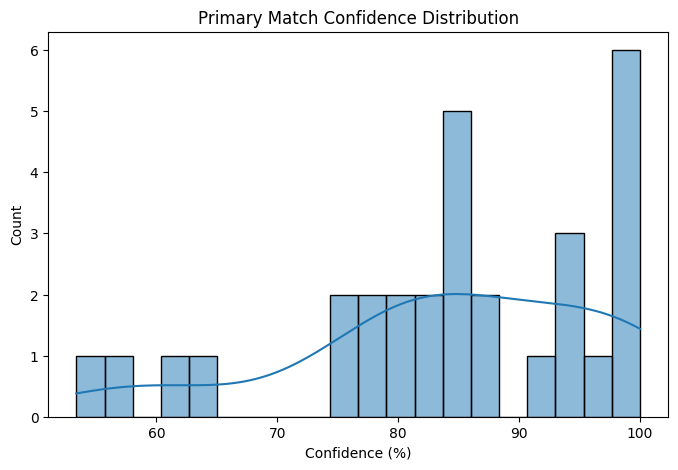

In [ ]:
results_df = pd.DataFrame(all_results)

results_df["primary_conf"] = results_df["primary_match"].apply(
    lambda x: float(x.get("Confidence").rstrip('%')) if x and x.get("Confidence") else None
)

plt.figure(figsize=(8,5))
sns.histplot(results_df["primary_conf"].dropna(), bins=20, kde=True)
plt.title("Primary Match Confidence Distribution")
plt.xlabel("Confidence (%)")
plt.ylabel("Count")
plt.show()




## The only 2 categories we don't get 100% accuracy for the primary match are dresses and tops.
## We successfully return 100% of bottoms/footwear and outwear.

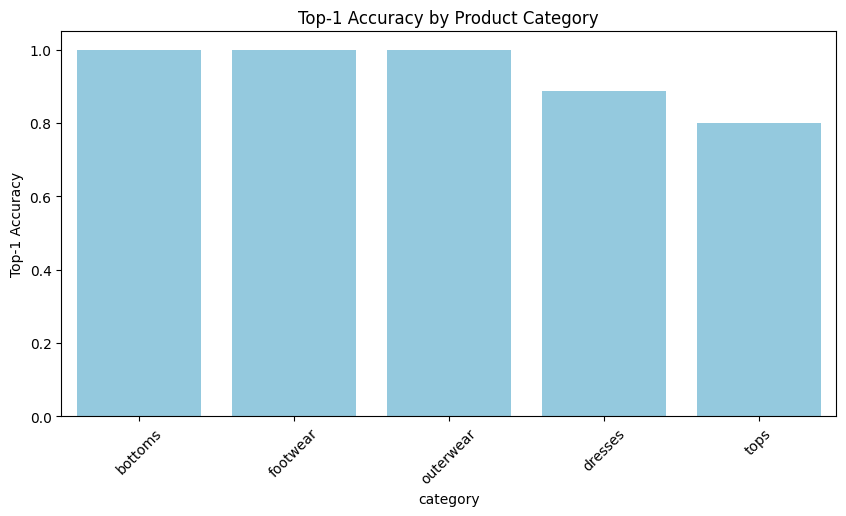

In [ ]:
results_df["category"] = results_df["extracted_attributes"].apply(lambda x: x.get("category") if x else None)
results_df["correct_top1"] = results_df["primary_match"].apply(lambda x: x.get("SKU") if x else None) == results_df["true_label"]
cat_acc = results_df.groupby("category")["correct_top1"].mean().sort_values(ascending=False)


plt.figure(figsize=(10,5))
sns.barplot(x=cat_acc.index, y=cat_acc.values, color="skyblue")
plt.xticks(rotation=45)
plt.ylabel("Top-1 Accuracy")
plt.title("Top-1 Accuracy by Product Category")
plt.show()

## As for False positives and False negatives, we only observe 2 False positives in the tops and dresses, as shown in the wrong predictions' analysis.

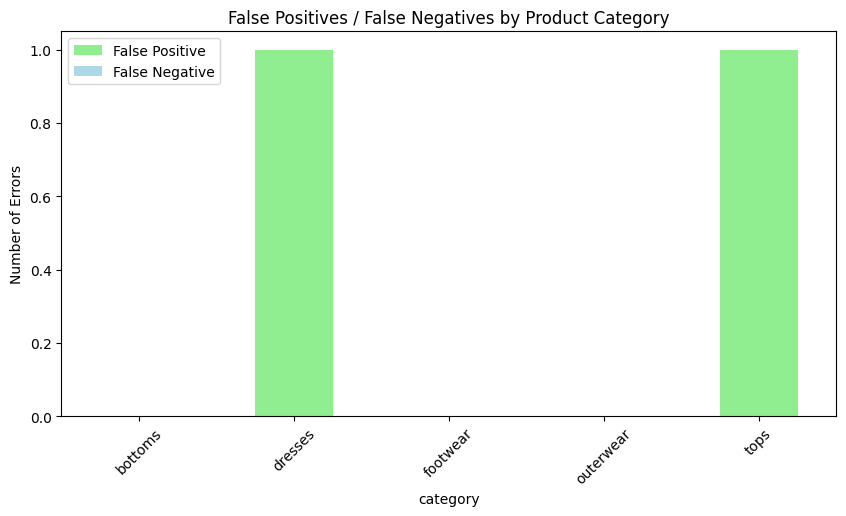

In [ ]:
results_df["primary_sku"] = results_df["primary_match"].apply(lambda x: x.get("SKU") if x else None)
results_df["false_positive"] = (~results_df["correct_top1"]) & results_df["primary_sku"].notna()
results_df["false_negative"] = (~results_df["correct_top1"]) & results_df["primary_sku"].isna()

fp_count = results_df.groupby("category")["false_positive"].sum()
fn_count = results_df.groupby("category")["false_negative"].sum()

fp_fn_df = pd.DataFrame({"False Positive": fp_count, "False Negative": fn_count})
fp_fn_df.plot(kind="bar", figsize=(10,5), stacked=True, color=["lightgreen", "lightblue"])
plt.xticks(rotation=45)
plt.ylabel("Number of Errors")
plt.title("False Positives / False Negatives by Product Category")
plt.show()